In [1]:
import cv2
import numpy as np

import matplotlib.pyplot as plt

from sklearn import neural_network
from sklearn import metrics
from sklearn.model_selection import train_test_split

import time
import os

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
list_of_files = os.listdir('train/')

### The cutest cat in the dataset

(A sample example of image in a dataset). Try and show different cats and dogs in the dataset and pick the cutest one.

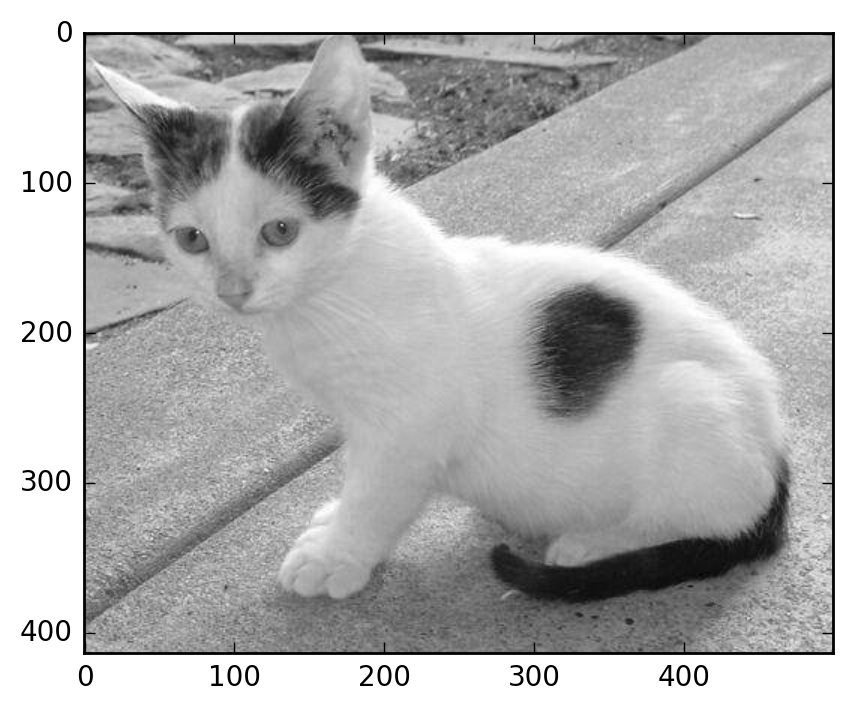

In [4]:
imgGray=cv2.imread('train/cat.3.jpg',0)
plt.imshow(imgGray, cmap='gray');

# Classification after equalization and resizing
### Separate the train_set into train_train and train_test and resizes the images

The following loop iterates through the list of images, resizes it to square images of size (target,target), flattens the vector and extracts the classes. The numpy vector classes contains the labels (0 for cats and 1 for dogs) and the features matrix contains the flattened images (each row has size target^2 (why?) ).

In [5]:
target = 40

features = np.zeros([len(list_of_files), target ** 2])
classes = np.zeros(len(list_of_files))

for i in range(len(list_of_files)):
    animal = list_of_files[i]
    img = cv2.imread('train/' + animal, 0)

    res = cv2.resize(img, (target, target))
    
    features[i] = res.reshape(-1) / 256
    if 'cat' in animal:
        classes[i] = 0
    elif 'dog' in animal:
        classes[i] = 1

### Split the dataset into train size (80%) and test size (20%) 

The following commands randomly shuffles the dataset into train and test. You can also do this using the sklearn.model_selection train_test_split function, but the for the purposes of this tutorial the following code will be preferable to display the images later on. 

In [8]:
train_size = int(len(list_of_files)*0.8)
np.random.seed(11)
random_shuffle = np.random.permutation(len(list_of_files))

train_index = random_shuffle[:train_size]
test_index = random_shuffle[train_size:]

[X_train, y_train, X_test, y_test] = [features[train_index], classes[train_index], features[test_index], classes[test_index]]

### "Centering" images

In [9]:
av=np.mean(X_train,axis=0)
X_train -= av

In [10]:
std = np.std(X_train,axis=0)
X_train /= std

## One-Hidden-Layer Neural Network on Centered/Normalized Input Bits

By default the neural newtork of sklearn uses the "log-loss" (or "cross-entropy") function as objective function for the classifier. This function is "finer" than accuracy (i.e., simply counting the number of correct classes). Assume that we only have two classes labeled as '0' or '1' and that our algorithm estimates the probability that the output is equal to $1$. Given the correct classes $y_i = 0$ or $1$ and $\hat{y}_i$ the estimated probability, the log loss function is

$$\text{log_loss} = -\frac{1}{N} \sum_{i=0}^N y_i \log \hat{y}_i + (1-y_i) \log (1-\hat{y}_i).$$

($0 \log 0 = 0$ by definition). Can you make sense of the log loss function? If not, ask Jan.

In [11]:
model = neural_network.MLPClassifier(hidden_layer_sizes=[1600],verbose=True)

In [12]:
start=time.time()
model.fit(X_train,y_train)
end=time.time()
print(end-start)

Iteration 1, loss = 1.02110170
Iteration 2, loss = 0.75907702
Iteration 3, loss = 0.55234297
Iteration 4, loss = 0.51731150
Iteration 5, loss = 0.51624732
Iteration 6, loss = 0.64583708
Iteration 7, loss = 0.46611655
Iteration 8, loss = 0.66863289
Iteration 9, loss = 0.53704075
Iteration 10, loss = 0.41494434
Iteration 11, loss = 0.37508825
Iteration 12, loss = 0.33889359
Iteration 13, loss = 0.30393393
Iteration 14, loss = 0.26350780
Iteration 15, loss = 0.29271226
Iteration 16, loss = 0.22185412
Iteration 17, loss = 1.18312278
Iteration 18, loss = 0.44403899
Iteration 19, loss = 0.61866599
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
190.71031403541565


### Calculating the accuracy and log loss of the model in the test set and showing a sample prediction

Remember that we have transfomed the training set by subtracting the average and dividing by the standard deviation. In order to make a correct prediction, before predicting we need to apply these transformations to the test set

In [13]:
predicted_classes = model.predict((X_test-av)/std)
predicted_probabilities = model.predict_proba((X_test-av)/std)

accuracy = metrics.accuracy_score(y_test, predicted_classes)
log_loss = metrics.log_loss(y_test,predicted_probabilities)

cm = metrics.confusion_matrix(y_test, predicted_classes)
print('accuracy: '+str(accuracy)+' logloss= '+str(log_loss))
print('confusionMatrix:')
print(cm/len(X_test))

accuracy: 0.614743856726 logloss= 0.884269310727
confusionMatrix:
[[ 0.32069971  0.18492295]
 [ 0.20033319  0.29404415]]


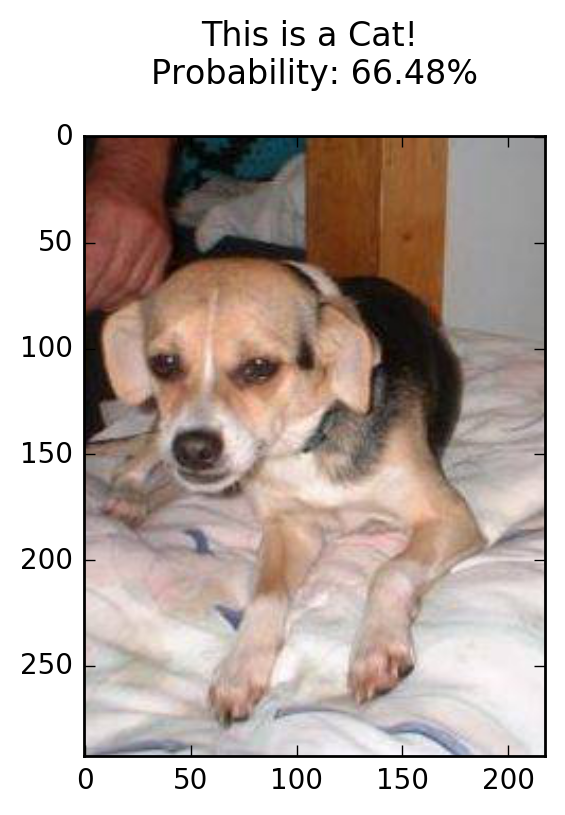

In [19]:
i = np.random.randint(len(test_index))

dic = {0:'Cat',1:'Dog'} 

testRGB = cv2.imread('train/'+list_of_files[test_index[i]])
testRGB = cv2.cvtColor(testRGB, cv2.COLOR_BGR2RGB)

image_to_predict = X_test[i].reshape(1,-1)

pred=model.predict_proba(image_to_predict)[0,0]

plt.title('This is a '+dic[pred<0.5]+'! \nProbability: '+str(round(100*((1-pred)*(pred<0.5)+pred*(pred>0.5)),2))+'%\n')
plt.imshow(testRGB);

## Conclusions 

Neural Nets with one hidden layer in the raw bits is NOT good for this task :) (but of course better than Logistic Regression). The best cross-validation accuracy achieved was around 61%. 

## See for yourself

Does increasing the resolution improve the performance? Is the change significant? Try and change the number/size of hidden layers. What are the parameters that gave you the best accuracy? 

## To think:

Does a better accuracy necessarily imply a better (smaller) log loss?

## Dodging the log-loss function

The following piece of code gives a better log-loss function, but the accuracy and confusion matrices remain the same: can you tell why?

In [22]:
predicted_classes = model.predict((X_test-av)/std)
predicted_probabilities = np.clip(model.predict_proba((X_test-av)/std),0.35,0.65)


accuracy = metrics.accuracy_score(y_test, predicted_classes)
log_loss = metrics.log_loss(y_test,predicted_probabilities)

cm = metrics.confusion_matrix(y_test, predicted_classes)
print('accuracy: '+str(accuracy)+' logloss= '+str(log_loss))
print('confusionMatrix:')
print(cm/len(X_test))


accuracy: 0.614743856726 logloss= 0.664343688858
confusionMatrix:
[[ 0.32069971  0.18492295]
 [ 0.20033319  0.29404415]]
